In [89]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [90]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [91]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [92]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [93]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [94]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [95]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [96]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [97]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
aggs = calc_temps("2014-01-01", "2014-12-31")
min_temp = aggs[0][0]
avg_temp = [aggs[0][1]]
max_temp = aggs[0][2]

print(min_temp, avg_temp, max_temp)
x_axis = np.arange(len(avg_temp))

56.0 [73.26453600308048] 85.0


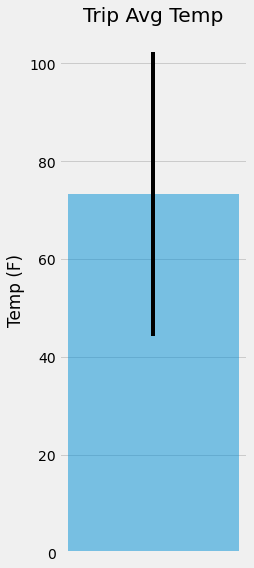

In [98]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3, 9))
ax.bar(x_axis, avg_temp, yerr=max_temp-min_temp, align='center', alpha=0.5, ecolor='black')
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")
ax.set_xticks([])
ax.yaxis.grid(True)


### Daily Rainfall Average

In [99]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Station.station, Station.name, Station.latitude,\
                        Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                        filter(Station.station == Measurement.station).\
                        filter(Measurement.date >= '2014-08-02').\
                        filter(Measurement.date <= '2014-08-15').\
                        group_by(Measurement.station).\
                        order_by(func.sum(Measurement.prcp)).all()
for row in results:
    print(row)

('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.02)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.56)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.75)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.0)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.76)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.78)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.260000000000002)


In [100]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [101]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2014-08-02'
end_date = '2014-08-15'

date_list = []
# Use the start and end date to create a range of dates
curr_date = start_date
while str(curr_date) <= str(end_date):
    date_split = str(curr_date).split("-")
    date_list.append(f"{date_split[1]}-{date_split[2]}")
    curr_date = dt.date(int(date_split[0]), int(date_split[1]), int(date_split[2])) + dt.timedelta(days=1)



# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for vacay_date in date_list:
    temp_data = daily_normals(vacay_date)
    normals.append([temp_data[0][0], temp_data[0][1], temp_data[0][2]])


In [102]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"], index=date_list)
df.head()

,tmin,tavg,tmax
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0


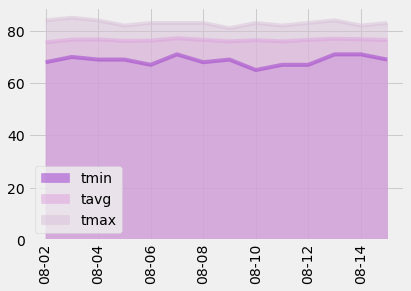

In [103]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ["darkorchid", "plum", "thistle"]
df.plot.area(stacked=False, rot=90, color=colors)
plt.show()

## Close Session

In [104]:
session.close()